For this task, we first applied the Hough line detection method 
 - Bilateral filtering was applied to retain edges while smoothing out noise. 
 - Next, to keep pixels containing the soccer pitch and remove the background, such as the stadium, a green mask was applied. 
 - To remove the remaining noise, we found all the contours of the image after the green mask, then extracted the largest contour and used it as a filter. 
 - As a final touch to fix contour outlines, an opening morphology was applied. The resulting image was passed through a canny transform, with adjusted thresholds: a low threshold of 98 and a high threshold of 260, for best detecting the edges. 
 - Finally, the output from Canny was passed as input to the Hough transform for performing line detection


Automatic Feature Detection Algorithms
The last effort was focused on feature detectors such as SIFT and ORB . These are
methods designed for detecting features in images and can be used to detect image similarities.
Thus, with these methods, one could detect corresponding points between the input frame and
the overview map. The resulting points could then be used in a perspective transformation. SIFT
and ORB were tested on the unprocessed input frame, and with a combination of the different
techniques described earlier, such as the green mask contour and the Hough line detection. SIFT
proved to be the most reliant of these methods and is subsequently included in the results

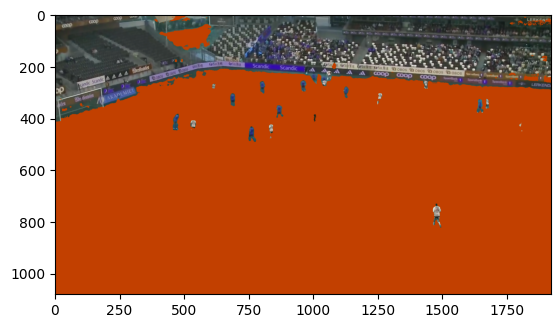

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import cv2

image = cv2.imread('testImage.jpg')

# Apply bilateral filter
filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

roi_lab = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2Lab)
roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)

roi_lab_filtered = cv2.cvtColor(roi_lab_filtered, cv2.COLOR_Lab2BGR)
plt.imshow(roi_lab_filtered)


Time taken to process video: 0.31626200675964355 seconds


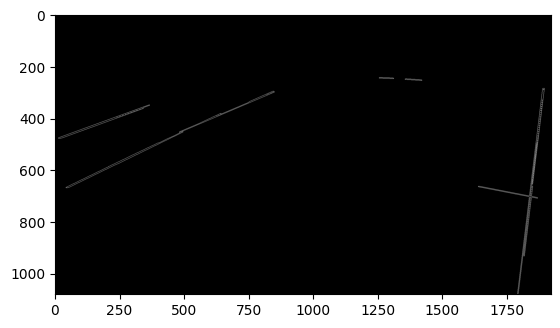

In [127]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

# Load image
image = cv2.imread('testImage.jpg')


start_time = time.time()
# Apply bilateral filter
filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

# Convert to HSV
hsv = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2HSV)

# Define range of green color in HSV
lower_green = np.array([30, 40, 40])   # Lower bound of green color
upper_green = np.array([90, 255, 255]) # Upper bound of green color

# Threshold the HSV image to get only green colors
mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

black_image = np.zeros_like(image)

# Filter contours by area and number of sides (adjust parameters as needed)
pitch_contour = max(contours, key = cv2.contourArea)
cv2.drawContours(black_image, [pitch_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))
black_image = cv2.morphologyEx(black_image, cv2.MORPH_OPEN, kernel)

# Apply the mask to the original image
result_image = cv2.bitwise_and(image, black_image)

edges = cv2.Canny(result_image, 10, 290)

# Apply Hough transform for line detection (adjust parameters as needed)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=50, maxLineGap=20)

black_image = np.zeros_like(image)
# Draw the detected lines on the original image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(black_image, (x1, y1), (x2, y2), (255, 255,255), 2)

    
edges = cv2.Canny(black_image, 0, 34)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=50, maxLineGap=300)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(result_image, (x1, y1), (x2, y2), (255, 255,255), 2)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken to process video: {execution_time} seconds")
# Show the final result with detected lines
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
def filter_out_color_LAB(roi_lab, lower_treshold, upper_treshold):
    # Getting the A channel and applying threshold
    a_channel = roi_lab[:,:,1]
    #127, 255
    _, mask = cv2.threshold(a_channel, lower_treshold, upper_treshold, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Using the mask to exclude green pixels in LAB
    roi_lab_filtered = roi_lab.copy()
    roi_lab_filtered[mask != 255] = 0
    return roi_lab_filtered

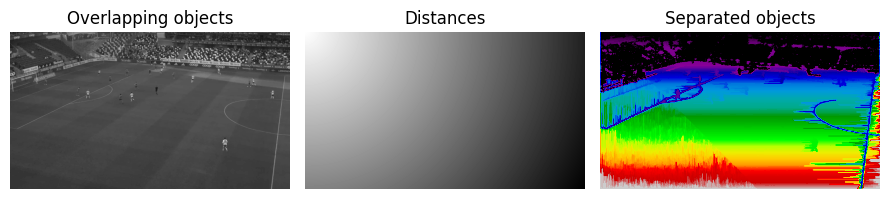

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import cv2

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

image = cv2.imread('testImage.jpg')
image = cv2.resize(image, (0, 0), fx = 0.7, fy = 0.7)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

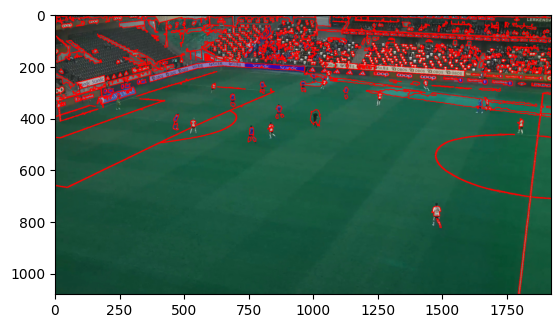

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy

im = cv2.imread("testImage.jpg")
B = im[:,:,2]
Y = 255-B

thresh = cv2.adaptiveThreshold(Y,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,35,5)

contours, hierarchy = cv2.findContours(thresh,  
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

x=[]
for i in range(0, len(contours)):
    if cv2.contourArea(contours[i]) > 100:
        x.append(contours[i])
cv2.drawContours(im, x, -1, (255,0,0), 2) 

plt.imshow(im)

In [ ]:
import matplotlib.pyplot as plt
import json
import os

# Load the JSON data
filename = "Calibration_Keypoint/00000.json"
with open(filename, 'r') as f:
    data = json.load(f)

# Load the image
img = plt.imread(filename.replace(".json", ".jpg"))  # assuming it's a .jpg, adjust as needed
plt.imshow(img)

# Plot each set of points
for key, points in data.items():
    # Extract x and y coordinates
    x = [point['x'] for point in points]
    y = [point['y'] for point in points]
    
    # Scale the coordinates to the image dimensions
    h, w, _ = img.shape
    x = [i * w for i in x]
    y = [j * h for j in y]
    
    # Draw the shape
    plt.plot(x, y, label=key, marker='o')

plt.axis('off')  # to hide axes

# Display or save the image
plt.show()
#plt.savefig(os.path.splitext(filename)[0] + "_output.jpg", bbox_inches='tight', pad_inches=0)


In [95]:
import torch
print(torch.version.cuda)

11.7
